<h1>Analysis 3 - Time series analysis using Ensemble methods</h1>

This is based on Shaohua Liu workbook Analysis 2 (20/5/2021)

The purpose of this workbook is to model the PBL heights using ensemble methods

In [18]:
#Various library imports
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date
from datetime import timedelta
from sklearn.preprocessing import StandardScaler

#Libraries for calculating metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

#Ensemble libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import AdaBoostRegressor

<h2>Section 1 - Preprocessing</h2>

<h3>1.1 Loading information</h3>

In [19]:
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

In [20]:
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [21]:
def convert_df_to_datetime_wrf(df):
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H:%M:%S')+ timedelta(hours=10)
    
    #Set index to datetime
    df = df.set_index('datetime')
    
    #Keep the last index
    #As per Hiep response - 24/8/2021 - we keep last value

    df = df[~df.index.duplicated(keep = 'last')]

    df = df.reset_index()
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [22]:
'''
2. Import WRF data and parse accordingly
'''

data_path = "D:\MSDS\DS Project\Data"

wrf_data_path = "\\WRF"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                       'PBLH_series329_20210218', 'PBLH_series329_20210219']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)

wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM_WRF(site, wrf_df):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner')
    return df_joined

def bl_plot(site, wrf_df):
    join_df = join_CL_CTM_WRF(site, wrf_df).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title=site)
    plt.show()

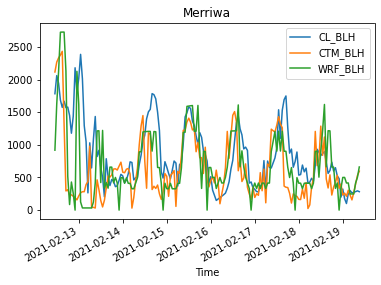

In [23]:
bl_plot('Merriwa', wrf_df_merriwa)


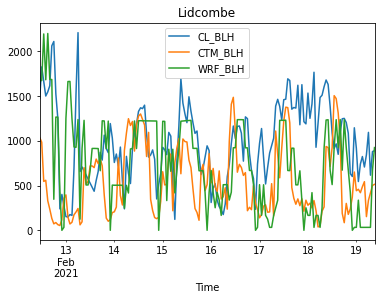

In [24]:
bl_plot('Lidcombe', wrf_df_lidcombe)


<h3>1.2 Loading AQMS data</h3>

In [8]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [9]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [10]:
df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]
#params

In [11]:
#TK 28/7/2021: Added BL diff - can/should we use this as a feature..?
#TK 31/8/2021: No you shouldn't....
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-20',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    
    if site == 'Merriwa':
        wrf_df = wrf_df_merriwa
    else:
        wrf_df = wrf_df_lidcombe
    
    df = join_CL_CTM_WRF(site, wrf_df).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [25]:
data = {site: bl_external(site, id) for site, id in sites.items()}

<h3>Section 1.3 - Final data prep</h3>

<h4>Data config</h4>

In [26]:
#Get data from dict
df_merriwa = data['Merriwa']
df_lidcombe = data['Lidcombe']


In [28]:
#Sanity check
df_lidcombe

,Date,Hour,CL_BLH,CTM_BLH,WRF_BLH,Carbon monoxide,Humidity,Nephelometer,Nitric Oxide,Nitrogen Dioxide,...,PM10,PM2.5,Rainfall,Solar radiation,Sulphur Dioxide,Temperature,Wind Direction (10m),Wind Direction Sigma Theta,Wind Speed (10m),BL_diff
0,2021-02-12,11,1474.222222,1035.7593,1669.35,0.149364,38.903,0.098,0.056400,0.432441,...,19.175,0.367,0.0,437.536,0.089996,29.653,331.739,26.645,2.549,438.462922
1,2021-02-12,12,1826.222222,984.8432,1674.54,0.146080,41.071,0.098,0.032354,0.480973,...,21.087,0.158,0.0,461.103,0.078456,29.344,341.122,26.520,2.536,841.379022
2,2021-02-12,13,1662.444444,546.3094,2194.04,0.146025,37.793,0.105,0.035266,0.328856,...,22.598,5.190,0.0,955.920,0.060462,31.621,351.062,28.473,3.029,1116.135044
3,2021-02-12,14,1500.755556,559.0942,1682.49,0.153295,33.679,0.104,0.036560,0.345746,...,21.240,7.388,0.0,747.303,0.068090,33.368,345.062,28.062,3.395,941.661356
4,2021-02-12,15,1546.844444,330.0530,2199.28,0.154233,33.654,0.100,0.016396,0.400050,...,22.086,2.361,0.0,413.177,0.066623,33.113,346.135,28.148,2.763,1216.791444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,2021-02-19,5,845.268328,152.9865,32.96,0.108488,95.137,0.358,0.084657,0.754212,...,24.486,4.106,2.4,3.262,-0.015445,20.604,85.998,43.991,1.010,692.281828
163,2021-02-19,6,1094.350000,335.2351,33.02,0.125778,99.544,0.354,0.347748,0.962891,...,28.849,4.764,0.0,79.226,-0.010618,20.732,75.933,38.038,1.132,759.114900
164,2021-02-19,7,616.111111,417.5187,33.06,0.100724,85.626,0.390,0.208687,0.526319,...,25.040,5.870,0.0,164.262,-0.014756,22.176,69.681,25.592,2.175,198.592411
165,2021-02-19,8,879.903145,501.2411,671.95,0.073916,72.780,0.336,0.087252,0.103809,...,23.031,2.794,0.0,658.881,-0.007662,24.262,68.341,30.295,2.748,378.662045


In [29]:
'''
There are NaNs in external factors. Just fill them in. This as opposed to dropping data with missing values
'''
def interpolate_external_factors(df):

    df['datetime'] = pd.to_datetime(df['Date'] +' '+ df['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    feature_list_all = [feature for feature in df.columns][4:len(df.columns)-2]

    for feature in feature_list_all:
        df[feature] = df.set_index('datetime')[feature].interpolate(method='time').values
        
    return df

In [30]:
df_merriwa_filled = interpolate_external_factors(df_merriwa)
df_lidcombe_filled = interpolate_external_factors(df_lidcombe)

In [31]:
#Creates functions with lags and differences up to d
def create_data_lags(df, d):
    
    df_func = df.copy(deep = True)

    for i in range(d):
        col_name = 'CL_BLH_lag'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].shift(i+1)

    #Double for loop not the best - but want to keep factors at different locations to each other to easier view
    for i in range(d):
        col_name = 'temp'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].diff(periods = i+1)
  
    #Shift this by one. So Diff(t) = PBLH(t-1) - PBLH(t-1-d)
    for i in range(d):
        col_name = 'CL_BLH_diff' + str(i+1)
        target_col = 'temp'+str(i+1)
        df_func[col_name] = df_func[target_col].shift(1)
    
    #Rolling mean
    for i in range(d-1):
        col_name = 'CL_BLH_rollmean' + str(i+2)
        df_func[col_name] = df_func['CL_BLH'].rolling(i+2).mean().shift(1)
    
    to_drop_list = ['temp1','temp2','temp3','temp4','temp5']
        
    df_func = df_func.drop(to_drop_list, axis = 1)
        
    return df_func

In [32]:
df_merriwa_wlags = create_data_lags(df_merriwa_filled, 5)
df_lidcombe_wlags = create_data_lags(df_lidcombe_filled, 5)

In [18]:
df_merriwa_wlags.head(10)

,Date,Hour,CL_BLH,CTM_BLH,WRF_BLH,Carbon monoxide,Humidity,Nephelometer,Nitric Oxide,Nitrogen Dioxide,...,CL_BLH_lag5,CL_BLH_diff1,CL_BLH_diff2,CL_BLH_diff3,CL_BLH_diff4,CL_BLH_diff5,CL_BLH_rollmean2,CL_BLH_rollmean3,CL_BLH_rollmean4,CL_BLH_rollmean5
0,2021-02-12,11,1782.971698,2116.5154,918.04,-0.013024,47.927,0.042,-0.023461,0.069158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-12,12,2060.904255,2268.4509,1629.29,-0.003834,46.820,0.051,-0.015987,0.076345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-12,13,1942.894737,2332.6211,2124.96,-0.004704,45.996,0.058,-0.011745,0.066663,...,NaN,277.932557,NaN,NaN,NaN,NaN,1921.937977,NaN,NaN,NaN
3,2021-02-12,14,1684.731183,2376.4629,2726.00,-0.003592,44.181,0.060,-0.026188,0.057879,...,NaN,-118.009518,159.923039,NaN,NaN,NaN,2001.899496,1928.923563,NaN,NaN
4,2021-02-12,15,1573.967391,2432.8503,2727.78,-0.002880,43.716,0.065,-0.021037,0.052190,...,NaN,-258.163554,-376.173073,-98.240515,NaN,NaN,1813.812960,1896.176725,1867.875468,NaN
5,2021-02-12,16,1668.378378,1316.0260,2727.64,0.004235,46.238,0.068,-0.020734,0.047798,...,1782.971698,-110.763791,-368.927346,-486.936864,-209.004307,NaN,1629.349287,1733.864437,1815.624392,1809.093853
6,2021-02-12,17,1569.719626,293.4471,2132.87,0.002853,48.946,0.070,-0.019623,0.053188,...,2060.904255,94.410987,-16.352804,-274.516358,-392.525877,-114.593320,1621.172885,1642.358984,1717.492922,1786.175189
7,2021-02-12,18,1578.604651,312.8919,518.45,-0.002314,52.111,0.068,-0.030633,0.068659,...,1942.894737,-98.658752,-4.247765,-115.011557,-373.175111,-491.184629,1619.049002,1604.021799,1624.199145,1687.938263
8,2021-02-12,19,1450.186706,232.0443,85.15,-0.011205,54.351,0.067,-0.026087,0.074348,...,1684.731183,8.885025,-89.773727,4.637260,-106.126532,-364.290086,1574.162139,1605.567552,1597.667512,1615.080246
9,2021-02-12,20,1178.113208,234.0902,430.46,-0.014778,56.331,0.065,-0.027401,0.083431,...,1573.967391,-128.417945,-119.532920,-218.191672,-123.780685,-234.544476,1514.395679,1532.836995,1566.722341,1568.171351


In [19]:
df_lidcombe_wlags.columns

Index(['Date', 'Hour', 'CL_BLH', 'CTM_BLH', 'WRF_BLH', 'Carbon monoxide',
       'Humidity', 'Nephelometer ', 'Nitric Oxide', 'Nitrogen Dioxide',
       'Ozone', 'PM10', 'PM2.5', 'Rainfall', 'Solar radiation',
       'Sulphur Dioxide', 'Temperature', 'Wind Direction (10m) ',
       'Wind Direction Sigma Theta', 'Wind Speed (10m)  ', 'BL_diff',
       'datetime', 'CL_BLH_lag1', 'CL_BLH_lag2', 'CL_BLH_lag3', 'CL_BLH_lag4',
       'CL_BLH_lag5', 'CL_BLH_diff1', 'CL_BLH_diff2', 'CL_BLH_diff3',
       'CL_BLH_diff4', 'CL_BLH_diff5', 'CL_BLH_rollmean2', 'CL_BLH_rollmean3',
       'CL_BLH_rollmean4', 'CL_BLH_rollmean5'],
      dtype='object')

<h2>Section 2 - Modelling and analysis</h2>

<h5>Defining the statistical comparison measures - as per analysis 1</h5>

In [33]:
'''
Sourced from: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

This basically looks like a modified version of R2?
'''

def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [34]:
'''
Calculate mean bias error
'''
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


In [35]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

In [36]:
'''
Sourced from: https://github.com/CamDavidsonPilon/Python-Numerics/blob/master/TimeSeries/MASE.py
'''

def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [37]:
'''
Function: Calculates and prints out the varoius metrics
'''

def satistical_comps_on_df(y_true, y_pred, train_series, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMean Absolute scaled error:%.5f' % (location, ioa, rmse, mae, mbe, dtw_dist, mase))

In [38]:
#Write into DF
def satistical_comps_on_df_to_df(y_true, y_pred, train_series):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    
    df = pd.DataFrame([ioa, rmse, mae, mbe, dtw_dist, mase])
    
    return df

<h3>2.1 Base comp stats - assuming gold standard is CT and WRF model</h3>

On CTM

In [39]:
satistical_comps_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.head(142)['CL_BLH'] , 'Merriwa CTM model')

At Merriwa CTM model
Index of agreement:0.83320
Root mean squared error:212.95909
Mean absoluate error:171.77558
Mean bias error:-21.58962
DTW distance:3611.44
Mean Absolute scaled error:0.90875


In [40]:
satistical_comps_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['CTM_BLH'],df_lidcombe_filled.head(142)['CL_BLH']  ,'Lidcombe CTM model')

At Lidcombe CTM model
Index of agreement:0.39774
Root mean squared error:585.35820
Mean absoluate error:505.07921
Mean bias error:-375.16142
DTW distance:12043.29
Mean Absolute scaled error:2.29637


On WRF

In [41]:
satistical_comps_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],df_merriwa_filled.head(142)['CL_BLH'] , 'Merriwa WRF model')

At Merriwa WRF model
Index of agreement:0.71512
Root mean squared error:318.60122
Mean absoluate error:243.62769
Mean bias error:114.60318
DTW distance:5243.58
Mean Absolute scaled error:1.28888


In [42]:
satistical_comps_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_filled.head(142)['CL_BLH'] ,'Lidcombe WRF model')

At Lidcombe WRF model
Index of agreement:0.52481
Root mean squared error:573.70993
Mean absoluate error:473.14111
Mean bias error:-428.84950
DTW distance:8962.80
Mean Absolute scaled error:2.15116


<h3>2.2 Ensemble modelling</h3>

<h5>Feature list generation</h5>

In [43]:
feature_list = ['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Ozone',
 'Temperature',
 'Wind Direction Sigma Theta']

In [44]:
feature_list_all = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-2]

feature_list_all

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ']

In [45]:
#Feature including BL diff as predictor.
feature_list_all_v2 = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-1]

In [46]:
#Feature list with lags
feature_list_all_wlags = feature_list_all.copy()

feature_list_all_wlags.extend(['CL_BLH_lag1', 'CL_BLH_lag2','CL_BLH_lag3','CL_BLH_lag4','CL_BLH_lag5'])

feature_list_all_wlags

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ',
 'CL_BLH_lag1',
 'CL_BLH_lag2',
 'CL_BLH_lag3',
 'CL_BLH_lag4',
 'CL_BLH_lag5']

In [47]:
#extend feature list with lags to include diffs:
feature_list_all_v3 = feature_list_all_wlags.copy()

feature_list_all_v3.extend(['CL_BLH_diff1', 'CL_BLH_diff2','CL_BLH_diff3','CL_BLH_diff4','CL_BLH_diff5'])

feature_list_all_v3

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ',
 'CL_BLH_lag1',
 'CL_BLH_lag2',
 'CL_BLH_lag3',
 'CL_BLH_lag4',
 'CL_BLH_lag5',
 'CL_BLH_diff1',
 'CL_BLH_diff2',
 'CL_BLH_diff3',
 'CL_BLH_diff4',
 'CL_BLH_diff5']

In [48]:
feature_list_all_v4 = feature_list_all_v3.copy()

feature_list_all_v4.extend(['CL_BLH_rollmean2','CL_BLH_rollmean3','CL_BLH_rollmean4','CL_BLH_rollmean5'])

feature_list_all_v4

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ',
 'CL_BLH_lag1',
 'CL_BLH_lag2',
 'CL_BLH_lag3',
 'CL_BLH_lag4',
 'CL_BLH_lag5',
 'CL_BLH_diff1',
 'CL_BLH_diff2',
 'CL_BLH_diff3',
 'CL_BLH_diff4',
 'CL_BLH_diff5',
 'CL_BLH_rollmean2',
 'CL_BLH_rollmean3',
 'CL_BLH_rollmean4',
 'CL_BLH_rollmean5']

<h5>Generic modelling functions</h5>

In [49]:
'''
Define a generic modeller function

Inputs:
- df: dataframe object
- feature_list: list of features
- target: target variable
- modeller: base model to fit
- scaling: boolean, True if standardise external factors, False otherwise

Returns:
- df_result: dataframe of results

'''

'''

TK 30/8/2021 - Adjusted to include scaling

This scales only external feature

Doesnt improve performance - makes it worse...
'''

def modeller(df, feature_list, target, modeller, scaling):
    '''
    Define train test split
    '''
    train = df.head(142).dropna()
    test = df.tail(24)
    
    scaler = StandardScaler()
    
    external_features = ['Carbon monoxide', 'Humidity', 'Nephelometer ', 'Nitric Oxide', 'Nitrogen Dioxide',
                         'Ozone', 'PM10', 'PM2.5', 'Rainfall', 'Sulphur Dioxide', 'Temperature',
                         'Wind Direction (10m) ', 'Wind Direction Sigma Theta', 'Wind Speed (10m)  ']
    
    lag_features = ['CL_BLH_lag1', 'CL_BLH_lag2', 'CL_BLH_lag3', 'CL_BLH_lag4', 'CL_BLH_lag5',
                    'CL_BLH_diff1', 'CL_BLH_diff2', 'CL_BLH_diff3', 'CL_BLH_diff4', 'CL_BLH_diff5',
                    'CL_BLH_rollmean2', 'CL_BLH_rollmean3', 'CL_BLH_rollmean4', 'CL_BLH_rollmean5']
    
    if scaling:
        scaler.fit(train[external_features])
        X_train = pd.DataFrame(scaler.transform(train[external_features]), columns = external_features)
        X_test = pd.DataFrame(scaler.transform(test[external_features]), columns = external_features)
        
        for lag_feature in lag_features:
            if lag_feature in feature_list:
                X_train[lag_feature] = train[lag_feature]
                X_test[lag_feature] = test[lag_feature]
    else:
        X_train = train[feature_list]
        X_test = test[feature_list]

    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model
    '''
    modeller.fit(X_train, y_train)

    '''
    Predict
    '''
    modeller_predict = modeller.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  modeller_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result


In [50]:
def pred_plots(df, title):
    resid_plot_title = 'Residual plots at '+ title
    pred_plot_title = 'Comparison of predicted BLH at ' + title
    
    sns.set_theme(style="whitegrid")

    # Make an example dataset with y ~ x
    x = df['CL_BLH']
    y = df['Predicted BLH']

    # Plot the residuals after fitting a linear model
    sns.residplot(x=x, y=y, lowess=True, color="g").set(title = resid_plot_title)
    df.plot(title = pred_plot_title)

In [51]:
def results_print(df, train_series, title):
    pred_plots(df, title)
    satistical_comps_on_df(df['CL_BLH'], df['Predicted BLH'], train_series, title)

<h4>GBM methods</h4>

<h4>XGBoost</h4>

General thoughts:
* Easy to train
* Does this overfit as number of trees increase? Need to think carefully
* Tuning hyper-params?
* Feature selection still an issue - H0 tests? ANOVA?

<h5>On all features</h5>

In [52]:
xgbm_model = XGBRegressor()

#on all external factors
df_merriwa_xgbm_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', xgbm_model, False)
df_lidcombe_xgbm_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', xgbm_model, False)

#Including lag variables
df_merriwa_xgbm_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', xgbm_model, False)
df_lidcombe_xgbm_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', xgbm_model, False)

#Including both lags and differences
df_merriwa_xgbm_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', xgbm_model, False)
df_lidcombe_xgbm_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', xgbm_model, False)

#Including lags, diff and rolling means
df_merriwa_xgbm_wlags_v3 = modeller(df_merriwa_wlags, feature_list_all_v4, 'CL_BLH', xgbm_model, False)
df_lidcombe_xgbm_wlags_v3 = modeller(df_lidcombe_wlags, feature_list_all_v4, 'CL_BLH', xgbm_model, False)

#Scaling dont work
# #Including lags and differences - scaled all features - including lags
# df_merriwa_xgbm_wlags_scaled = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', xgbm_model, True)
# df_lidcombe_xgbm_wlags_scaled = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', xgbm_model, True)



C:\Users\thoma\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


At Merriwa XGBM all features
Index of agreement:0.73466
Root mean squared error:319.03948
Mean absoluate error:280.90060
Mean bias error:280.90060
DTW distance:6940.82
Mean Absolute scaled error:1.48606


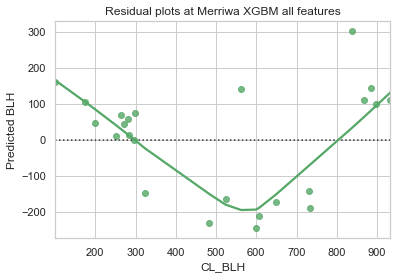

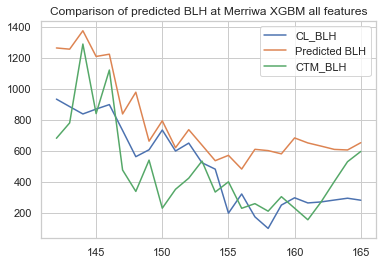

In [151]:
results_print(df_merriwa_xgbm_all, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa XGBM all features')

At Lidcombe XGBM all features
Index of agreement:0.55294
Root mean squared error:358.77947
Mean absoluate error:277.25321
Mean bias error:51.77140
DTW distance:6171.76
Mean Absolute scaled error:1.26055


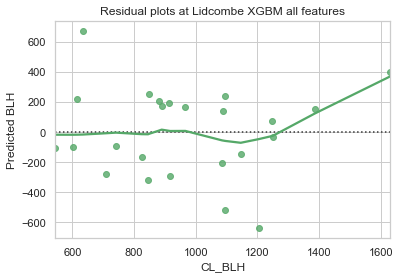

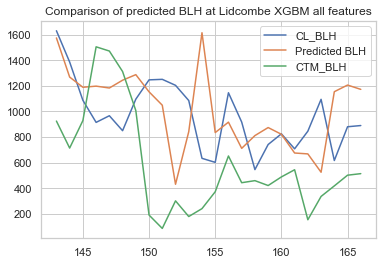

In [84]:
results_print(df_lidcombe_xgbm_all, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe XGBM all features')

At Merriwa XGBM with lags
Index of agreement:0.74297
Root mean squared error:264.16250
Mean absoluate error:221.04900
Mean bias error:211.15922
DTW distance:3812.60
Mean Absolute scaled error:1.16943


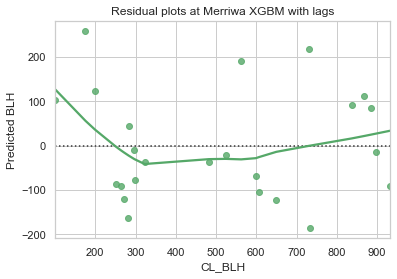

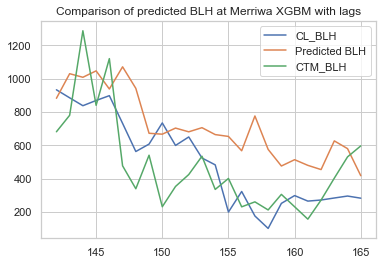

In [152]:
results_print(df_merriwa_xgbm_wlags, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa XGBM with lags')

At Lidcombe XGBM with lags
Index of agreement:0.79705
Root mean squared error:234.44173
Mean absoluate error:181.17055
Mean bias error:43.12437
DTW distance:2551.00
Mean Absolute scaled error:0.82370


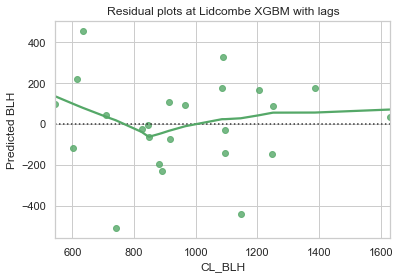

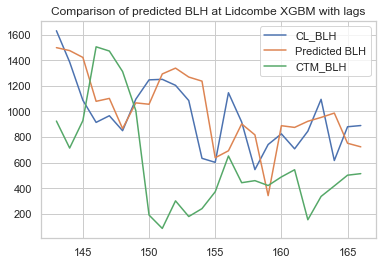

In [98]:
results_print(df_lidcombe_xgbm_wlags, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe XGBM with lags')

At Merriwa XGBM with lags and diffs
Index of agreement:0.77700
Root mean squared error:237.93083
Mean absoluate error:201.33734
Mean bias error:197.41916
DTW distance:3714.08
Mean Absolute scaled error:1.06514


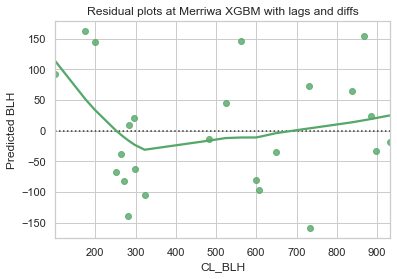

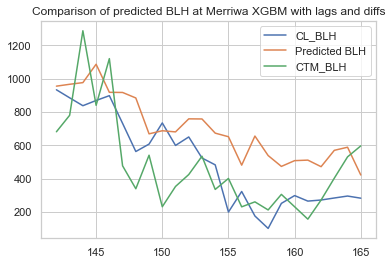

In [153]:
results_print(df_merriwa_xgbm_wlags_v2, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa XGBM with lags and diffs')

At Merriwa XGBM with lags and diffs
Index of agreement:0.74704
Root mean squared error:263.18054
Mean absoluate error:206.92253
Mean bias error:24.43678
DTW distance:2947.93
Mean Absolute scaled error:0.94078


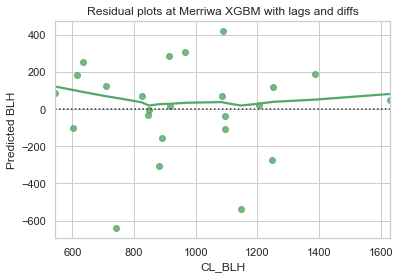

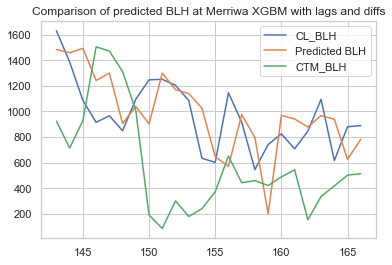

In [154]:
results_print(df_lidcombe_xgbm_wlags_v2, df_lidcombe_filled.head(142)['CL_BLH'],'Merriwa XGBM with lags and diffs')

At Merriwa XGBM with lags, diffs and rolling means
Index of agreement:0.79796
Root mean squared error:218.06106
Mean absoluate error:179.46262
Mean bias error:168.12956
DTW distance:2919.42
Mean Absolute scaled error:0.94942


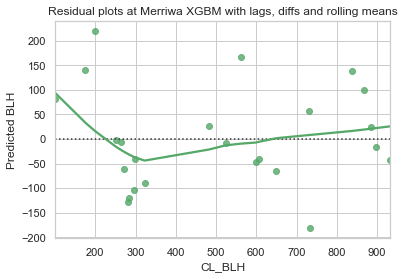

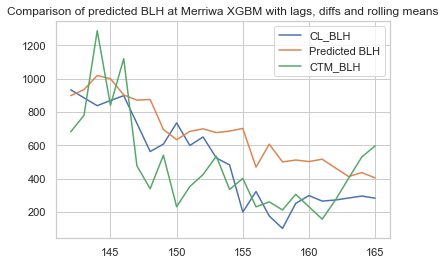

In [40]:
results_print(df_merriwa_xgbm_wlags_v3, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa XGBM with lags, diffs and rolling means')

At Lidcombe XGBM with lags, diffs and rolling means
Index of agreement:0.75980
Root mean squared error:245.35570
Mean absoluate error:203.05928
Mean bias error:41.00596
DTW distance:2323.33
Mean Absolute scaled error:0.92322


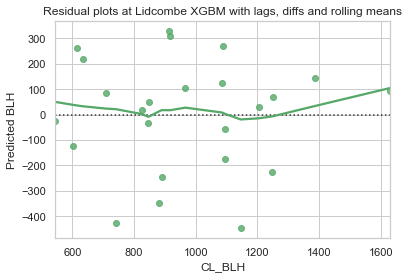

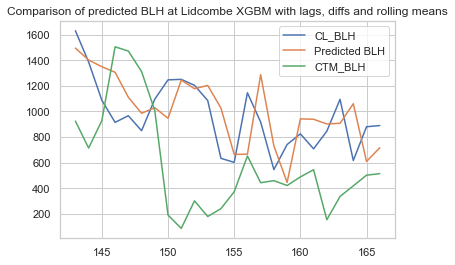

In [41]:
results_print(df_lidcombe_xgbm_wlags_v3, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe XGBM with lags, diffs and rolling means')

Clear case for inclusion of lags and differences in model

At Merriwa XGBM with lags and diffs - features scaled
Index of agreement:0.61596
Root mean squared error:490.47241
Mean absoluate error:407.89179
Mean bias error:397.58767
DTW distance:9330.62
Mean Absolute scaled error:2.15789


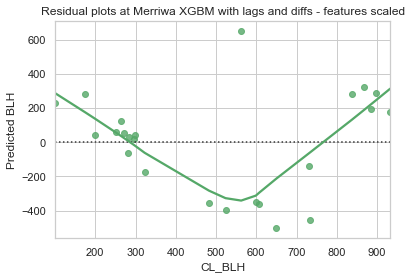

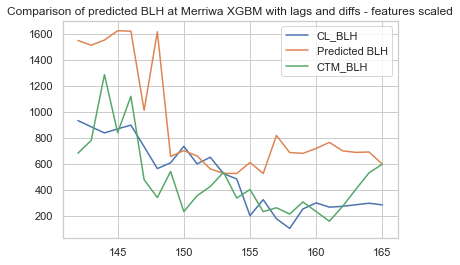

In [115]:
results_print(df_merriwa_xgbm_wlags_scaled, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa XGBM with lags and diffs - features scaled')

At Lidcombe XGBM with lags and diffs - features scaled
Index of agreement:0.50637
Root mean squared error:421.27878
Mean absoluate error:316.76174
Mean bias error:196.26353
DTW distance:5539.68
Mean Absolute scaled error:1.44017


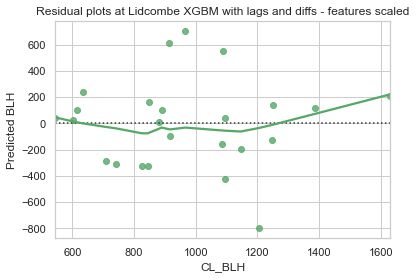

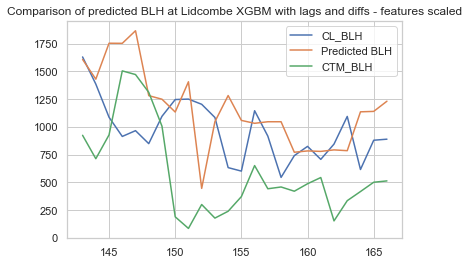

In [116]:
results_print(df_lidcombe_xgbm_wlags_scaled, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe XGBM with lags and diffs - features scaled')

Scaling dont work.

<h5>Light GBM</h5>

In [53]:
lgbm_model = LGBMRegressor()

#On external factors only
df_merriwa_lgbm_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', lgbm_model, False)
df_lidcombe_lgbm_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', lgbm_model, False)

#On external factors with lags
df_merriwa_lgbm_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', lgbm_model, False)
df_lidcombe_lgbm_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', lgbm_model, False)

#On external factors with lags and differences
df_merriwa_lgbm_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', lgbm_model, False)
df_lidcombe_lgbm_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', lgbm_model, False)

#On external factors with lags, diff and rolling means
df_merriwa_lgbm_wlags_v3 = modeller(df_merriwa_wlags, feature_list_all_v4, 'CL_BLH', lgbm_model, False)
df_lidcombe_lgbm_wlags_v3 = modeller(df_lidcombe_wlags, feature_list_all_v4, 'CL_BLH', lgbm_model, False)

# #On external factors scaled with lags and differences
# df_merriwa_lgbm_wlags_scaled = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', lgbm_model, True)
# df_lidcombe_lgbm_wlags_scaled = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', lgbm_model, True)

At Merriwa LGBM all features
Index of agreement:0.65167
Root mean squared error:362.40321
Mean absoluate error:314.66247
Mean bias error:314.66247
DTW distance:6204.35
Mean Absolute scaled error:1.66467


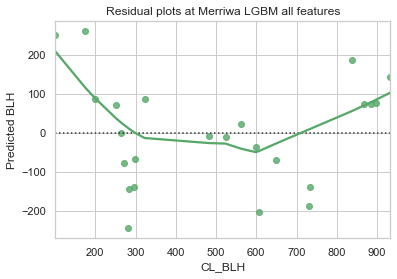

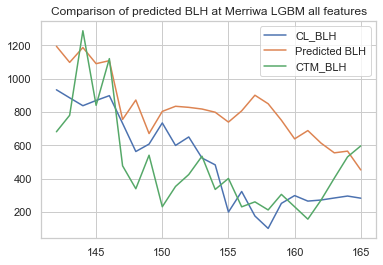

In [106]:
results_print(df_merriwa_lgbm_all, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa LGBM all features')

At Lidcombe LGBM all features
Index of agreement:0.69446
Root mean squared error:270.12467
Mean absoluate error:226.50930
Mean bias error:88.98863
DTW distance:4192.09
Mean Absolute scaled error:1.02984


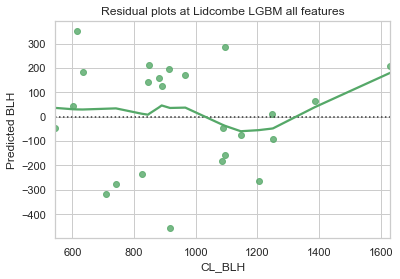

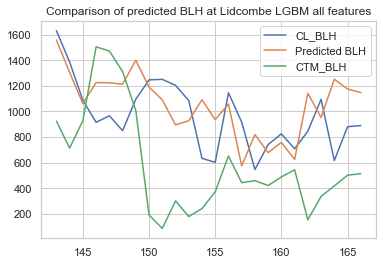

In [107]:
results_print(df_lidcombe_lgbm_all, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe LGBM all features')

At Merriwa LGBM with lags
Index of agreement:0.76235
Root mean squared error:261.12905
Mean absoluate error:225.45064
Mean bias error:216.87372
DTW distance:2666.23
Mean Absolute scaled error:1.19271


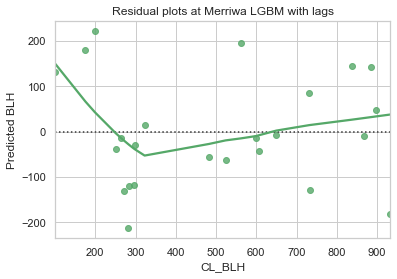

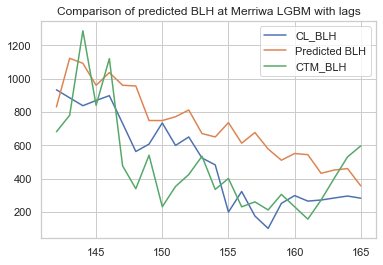

In [108]:
results_print(df_merriwa_lgbm_wlags, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa LGBM with lags')

At Lidcombe LGBM with lags
Index of agreement:0.75462
Root mean squared error:249.02426
Mean absoluate error:208.36751
Mean bias error:60.02794
DTW distance:3811.16
Mean Absolute scaled error:0.94735


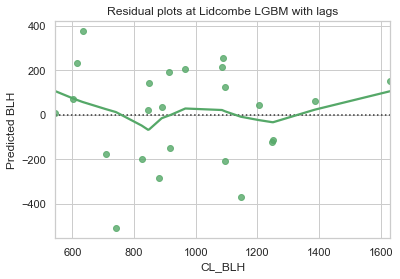

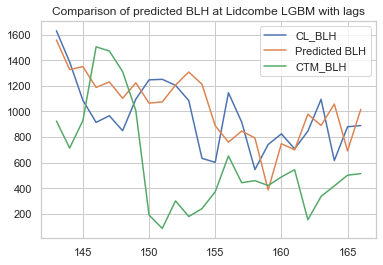

In [109]:
results_print(df_lidcombe_lgbm_wlags, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe LGBM with lags')

At Merriwa LGBM with lags, diff and rolling means
Index of agreement:0.79207
Root mean squared error:240.31074
Mean absoluate error:201.15211
Mean bias error:196.14326
DTW distance:2499.29
Mean Absolute scaled error:1.06416


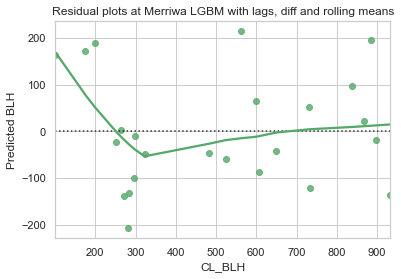

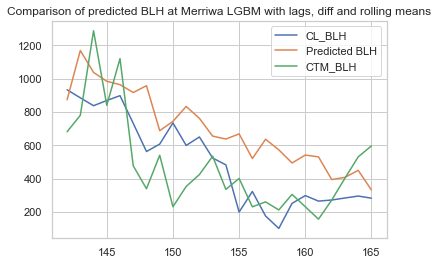

In [167]:
results_print(df_merriwa_lgbm_wlags_v3, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa LGBM with lags, diff and rolling means')

At Lidcombe LGBM with lags, diff and rolling means
Index of agreement:0.77999
Root mean squared error:234.66857
Mean absoluate error:184.60753
Mean bias error:43.73330
DTW distance:2388.41
Mean Absolute scaled error:0.83933


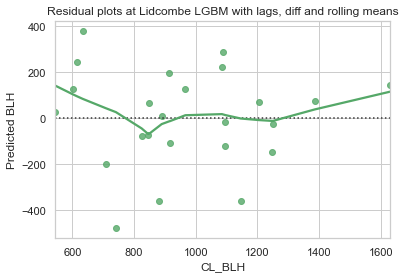

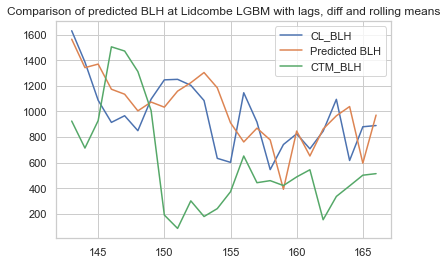

In [168]:
results_print(df_lidcombe_lgbm_wlags_v3, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe LGBM with lags, diff and rolling means')

<h5>AdaBoost</h5>

In [54]:
ada_model = AdaBoostRegressor()

#On external factors only
df_merriwa_ada_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', ada_model, False)
df_lidcombe_ada_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', ada_model, False)

#On external factors with lags
df_merriwa_ada_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', ada_model, False)
df_lidcombe_ada_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', ada_model, False)

#On external factors with lags and differences
df_merriwa_ada_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', ada_model, False)
df_lidcombe_ada_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', ada_model, False)

#On external factors with lags, differences and rolling means
df_merriwa_ada_wlags_v3 = modeller(df_merriwa_wlags, feature_list_all_v4, 'CL_BLH', ada_model, False)
df_lidcombe_ada_wlags_v3 = modeller(df_lidcombe_wlags, feature_list_all_v4, 'CL_BLH', ada_model, False)


# #On external factors scaled with lags and differences
# df_merriwa_ada_wlags_scaled = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', ada_model, True)
# df_lidcombe_ada_wlags_scaled = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', ada_model, True)


When you rerun- you dont get same answer..?? Not stable perhaps discard

At Merriwa ADA all features
Index of agreement:0.72219
Root mean squared error:324.06817
Mean absoluate error:288.89491
Mean bias error:288.89491
DTW distance:4566.11
Mean Absolute scaled error:1.52835


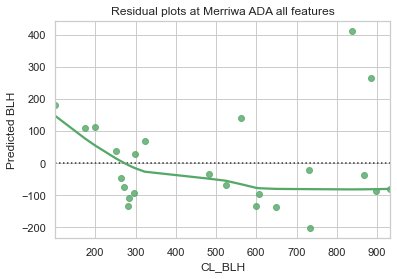

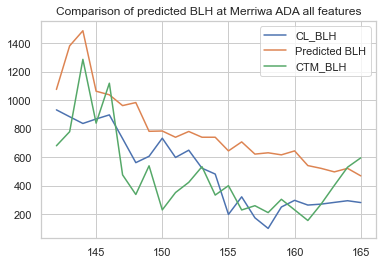

In [122]:
results_print(df_merriwa_ada_all, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa ADA all features')

At Lidcombe ADA all features
Index of agreement:0.49272
Root mean squared error:319.59869
Mean absoluate error:264.59535
Mean bias error:159.53678
DTW distance:4957.85
Mean Absolute scaled error:1.20300


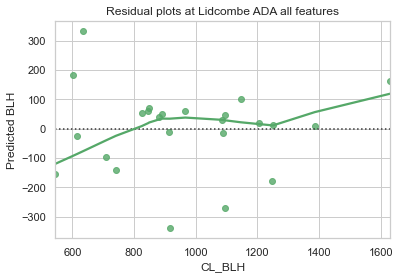

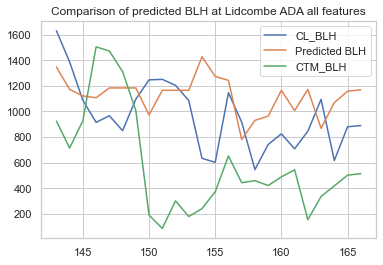

In [123]:
results_print(df_lidcombe_ada_all, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe ADA all features')

At Merriwa ADA with lags
Index of agreement:0.77789
Root mean squared error:242.25496
Mean absoluate error:208.13622
Mean bias error:202.28805
DTW distance:4407.28
Mean Absolute scaled error:1.10111


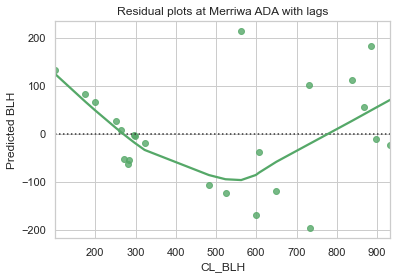

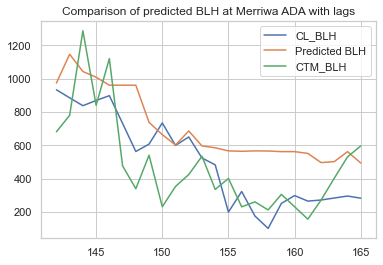

In [124]:
results_print(df_merriwa_ada_wlags, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa ADA with lags')

At Lidcombe ADA with lags
Index of agreement:0.77929
Root mean squared error:218.73514
Mean absoluate error:174.82954
Mean bias error:35.88098
DTW distance:1989.81
Mean Absolute scaled error:0.79487


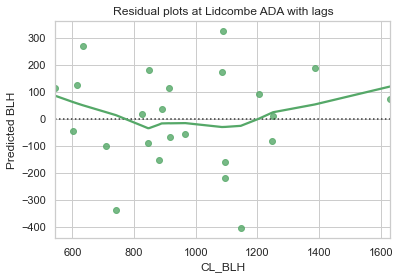

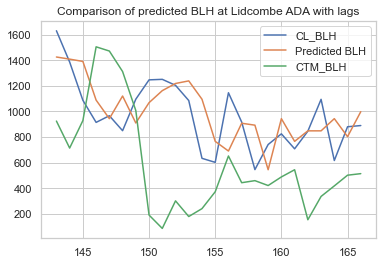

In [125]:
results_print(df_lidcombe_ada_wlags, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe ADA with lags')

At Merriwa ADA with lags, diff and rolling means
Index of agreement:0.77736
Root mean squared error:210.81064
Mean absoluate error:177.30151
Mean bias error:144.54148
DTW distance:3349.79
Mean Absolute scaled error:0.93799


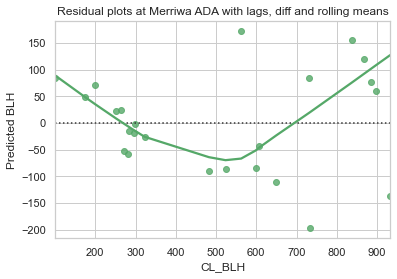

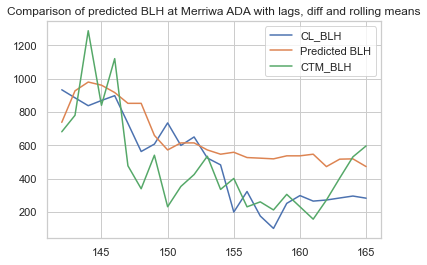

In [170]:
results_print(df_merriwa_ada_wlags_v3, df_merriwa_filled.head(142)['CL_BLH'],'Merriwa ADA with lags, diff and rolling means')

At Lidcombe ADA with lags, diff and rolling means
Index of agreement:0.75192
Root mean squared error:231.70671
Mean absoluate error:191.19328
Mean bias error:23.89889
DTW distance:1929.63
Mean Absolute scaled error:0.86927


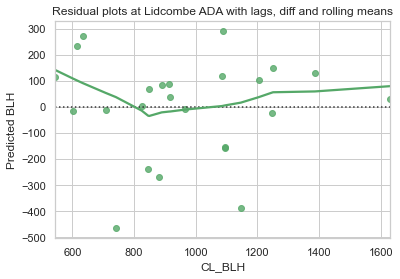

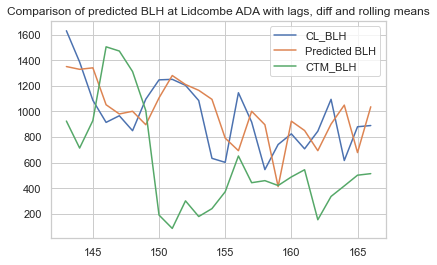

In [171]:
results_print(df_lidcombe_ada_wlags_v3, df_lidcombe_filled.head(142)['CL_BLH'],'Lidcombe ADA with lags, diff and rolling means')

<h2>Section 3 - Summary of results</h2>

NB: you need to have run the models below to plot.

In [55]:
def combine_data_plots(df_filled, results_df, col_names_df):
    time_stamp_index = df_filled.tail(24)['datetime']

    df_combined = pd.DataFrame(df_filled.tail(24)['CL_BLH'])

    for i in range(0, len(results_df)):
        df_combined[col_names_df[i]] = results_df[i]

    df_combined = df_combined.set_index(time_stamp_index)
    
    return df_combined


<h4>3.1 Considering the comparison between external factors and lags in ensemble methods</h4>

In [56]:
results_df_merriwa_v3 = [df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.tail(24)['WRF_BLH'], 
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH']]

results_df_lidcombe_v3 = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'],df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'],df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH']]


col_names_df_v3 = ['CTM BLH', 'WRF BLH',
           'XGBM all', 'LGBM all', 'AdaBoost all', 
           'XGBM with lags', 'LGBM with lags', 'AdaBoost with lags']

df_combined_predicted_merriwa_v3 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v3, col_names_df_v3)
df_combined_predicted_lidcombe_v3 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v3, col_names_df_v3)


In [57]:
def combined_predicted_plots_v3(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    
    
    ax.lines[6].set_color('magenta')
    ax.lines[6].set_linestyle('dashdot')
    ax.lines[6].set_linewidth(2)
    
    ax.lines[7].set_color('purple')
    ax.lines[7].set_linestyle('dashdot')
    ax.lines[7].set_linewidth(2)

    ax.lines[8].set_color('brown')
    ax.lines[8].set_linestyle('dashdot')
    ax.lines[8].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    ax.grid()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

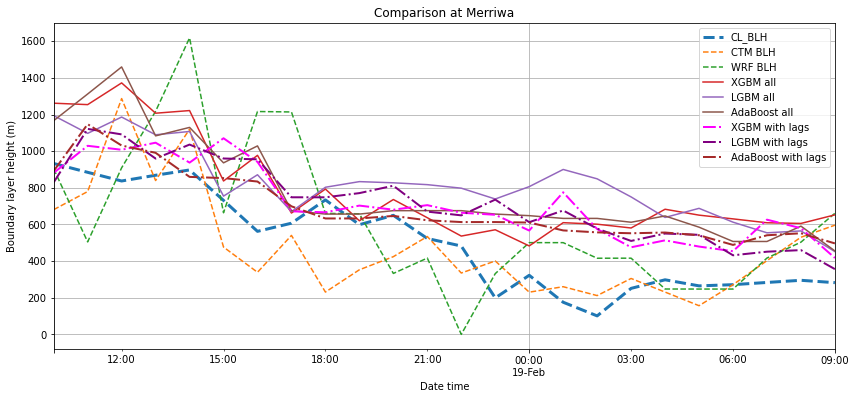

In [58]:
combined_predicted_plots_v3(df_combined_predicted_merriwa_v3, 'Comparison at Merriwa')

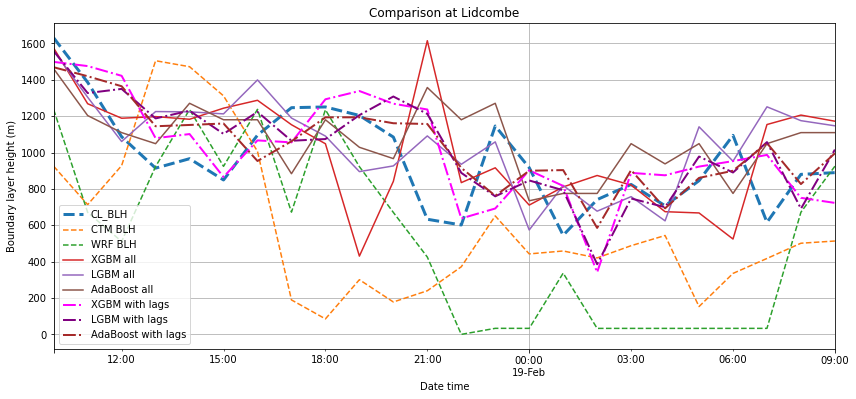

In [59]:
combined_predicted_plots_v3(df_combined_predicted_lidcombe_v3, 'Comparison at Lidcombe')

Including lags is somewhat of an improvement in the model

<h4>3.2 - Considering the inclusion of lags windows and differences in analysis</h4>

In [60]:
results_df_merriwa_v5 = [df_merriwa_filled.tail(24)['CTM_BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH']]

results_df_lidcombe_v5 = [df_lidcombe_filled.tail(24)['CTM_BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'],df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'],df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH']]


col_names_df_v5 = ['CTM BLH', 
           'XGBM with lags', 'LGBM with lags', 'AdaBoost with lags',
           'XGBM with lags + diff', 'LGBM with lags + diff', 'AdaBoost with lags + diff']

df_combined_predicted_merriwa_v5 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v5, col_names_df_v5)
df_combined_predicted_lidcombe_v5 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v5, col_names_df_v5)


In [61]:
def combined_predicted_plots_v5(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    
    #With lags df
    ax.lines[2].set_color('olive')
    ax.lines[2].set_linestyle('dashdot')
    ax.lines[2].set_linewidth(2)
    
    ax.lines[3].set_color('magenta')
    ax.lines[3].set_linestyle('dashdot')
    ax.lines[3].set_linewidth(2)

    ax.lines[4].set_color('purple')
    ax.lines[4].set_linestyle('dashdot')
    ax.lines[4].set_linewidth(2)
    
    #With lags + diff
    ax.lines[5].set_color('olive')
#     ax.lines[5].set_linestyle('dashdot')
#     ax.lines[5].set_linewidth(2)
    
    ax.lines[6].set_color('magenta')
#     ax.lines[6].set_linestyle('dashdot')
#     ax.lines[6].set_linewidth(2)

    ax.lines[7].set_color('purple')
#     ax.lines[7].set_linestyle('dashdot')
#     ax.lines[7].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    ax.grid()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

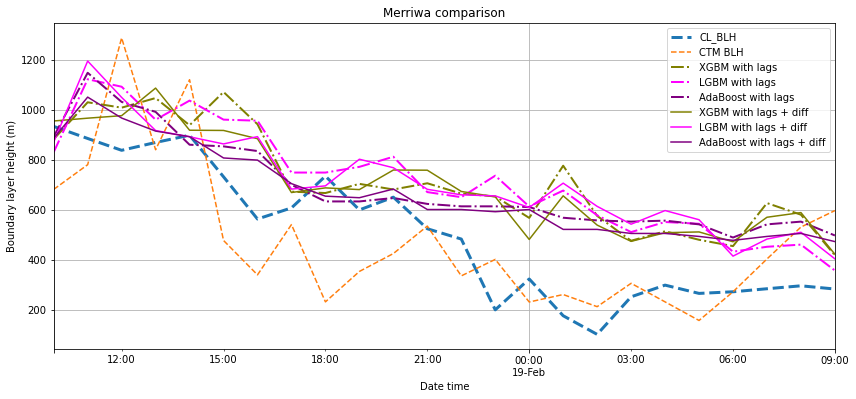

In [62]:
combined_predicted_plots_v5(df_combined_predicted_merriwa_v5, "Merriwa comparison")

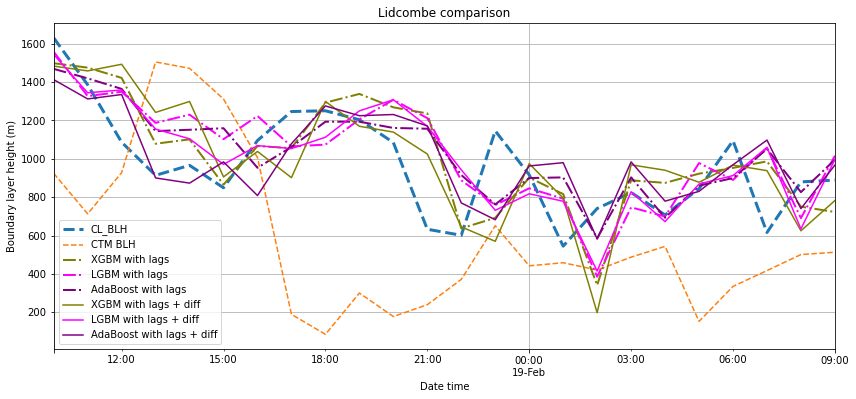

In [63]:
combined_predicted_plots_v5(df_combined_predicted_lidcombe_v5, "Lidcombe comparison")

Adding window differences makes massive impact on prediction

<h4>3.3 - Considering the inclusion of rolling means</h4>

In [64]:
results_df_merriwa_v6 = [df_merriwa_filled.tail(24)['CTM_BLH'], 
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH'],
        df_merriwa_xgbm_wlags_v3['Predicted BLH'], df_merriwa_lgbm_wlags_v3['Predicted BLH'], df_merriwa_ada_wlags_v3['Predicted BLH']]

results_df_lidcombe_v6 = [df_lidcombe_filled.tail(24)['CTM_BLH'], 
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'],df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH'],
        df_lidcombe_xgbm_wlags_v3['Predicted BLH'],df_lidcombe_lgbm_wlags_v3['Predicted BLH'], df_lidcombe_ada_wlags_v3['Predicted BLH']]


col_names_df_v6 = ['CTM BLH', 
                  'XGBM with lags + diff', 'LGBM with lags + diff', 'AdaBoost with lags + diff',
                  'XGBM with lags + diff + rolling means', 'LGBM with lags + diff + rolling means', 'AdaBoost with lags + diff + rolling means',]

df_combined_predicted_merriwa_v6 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v6, col_names_df_v6)
df_combined_predicted_lidcombe_v6 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v6, col_names_df_v6)


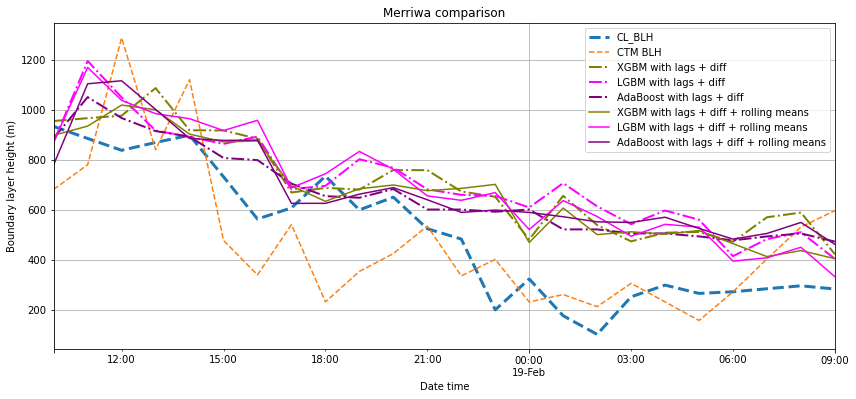

In [65]:
combined_predicted_plots_v5(df_combined_predicted_merriwa_v6, "Merriwa comparison")

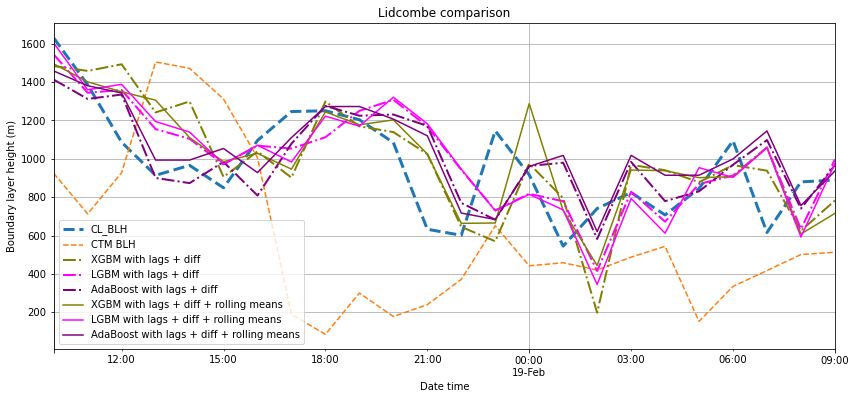

In [66]:
combined_predicted_plots_v5(df_combined_predicted_lidcombe_v6, "Lidcombe comparison")

<h4>3.3 - Select results - comparing external factors only vs external factors with window lags and differences</h4>

For Friday

In [67]:
results_df_merriwa_extfact = [df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.tail(24)['WRF_BLH'], 
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH']] 

results_df_lidcombe_extfact = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'],df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH']]
                         
col_names_df_extfact = ['CTM BLH', 'WRF BLH',
           'XGBM all external factors', 'LGBM all external factors', 'AdaBoost all external factors']

results_df_merriwa_wlags_v2 = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH']]

results_df_lidcombe_wlags_v2 = [df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'],df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH']]

col_names_df_wlags_v2 = ['CTM BLH', 'WRF BLH',
           'XGBM with lags and differences up to 5', 'LGBM with lags and differences up to 5', 'AdaBoost with lags and differences up to 5']


results_df_merriwa_wlags_v3 = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_wlags_v3['Predicted BLH'], df_merriwa_lgbm_wlags_v3['Predicted BLH'], df_merriwa_ada_wlags_v3['Predicted BLH']]

results_df_lidcombe_wlags_v3 = [df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_wlags_v3['Predicted BLH'],df_lidcombe_lgbm_wlags_v3['Predicted BLH'], df_lidcombe_ada_wlags_v3['Predicted BLH']]

col_names_df_wlags_v3 = ['CTM BLH', 'WRF BLH',
           'XGBM model', 'LGBM model', 'AdaBoost model']


df_combined_predicted_merriwa_extfact = combine_data_plots(df_merriwa_filled, results_df_merriwa_extfact, col_names_df_extfact)
df_combined_predicted_lidcombe_extfact = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_extfact, col_names_df_extfact)

df_combined_predicted_merriwa_wlags_v2 = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v2, col_names_df_wlags_v2)
df_combined_predicted_lidcombe_wlags_v2 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v2, col_names_df_wlags_v2)

df_combined_predicted_merriwa_wlags_v3 = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v3, col_names_df_wlags_v3)
df_combined_predicted_lidcombe_wlags_v3 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v3, col_names_df_wlags_v3)


In [68]:
def combined_predicted_plots_extfact(df, title):
    ax = df.plot(figsize = (10,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM/WRF BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    #Reset legend
    ax.legend()
    ax.grid()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)

In [69]:
def combined_predicted_plots_wlags_v2(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
 
    #With lags df
    ax.lines[3].set_color('red')
    ax.lines[3].set_linestyle('dashdot')
    ax.lines[3].set_linewidth(2)
    
    ax.lines[4].set_color('purple')
    ax.lines[4].set_linestyle('dashdot')
    ax.lines[4].set_linewidth(2)

    ax.lines[5].set_color('brown')
    ax.lines[5].set_linestyle('dashdot')
    ax.lines[5].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    ax.grid()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)

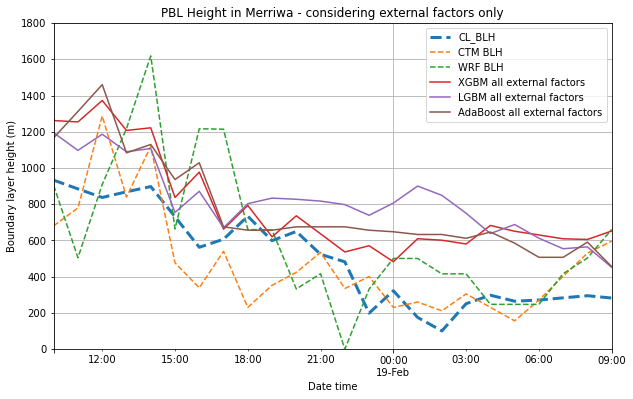

In [70]:
combined_predicted_plots_extfact(df_combined_predicted_merriwa_extfact, 'PBL Height in Merriwa - considering external factors only')

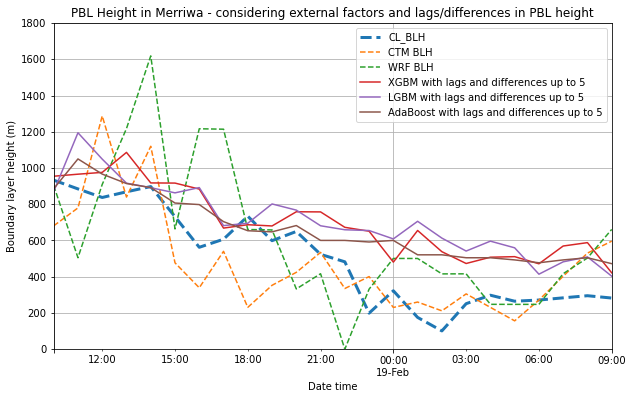

In [71]:
combined_predicted_plots_extfact(df_combined_predicted_merriwa_wlags_v2, 'PBL Height in Merriwa - considering external factors and lags/differences in PBL height')

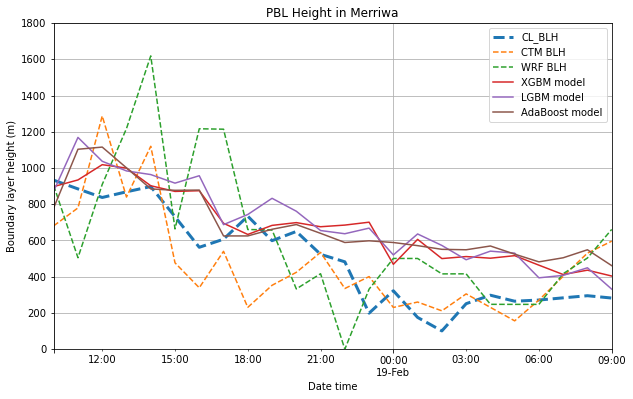

In [72]:
combined_predicted_plots_extfact(df_combined_predicted_merriwa_wlags_v3, 'PBL Height in Merriwa')

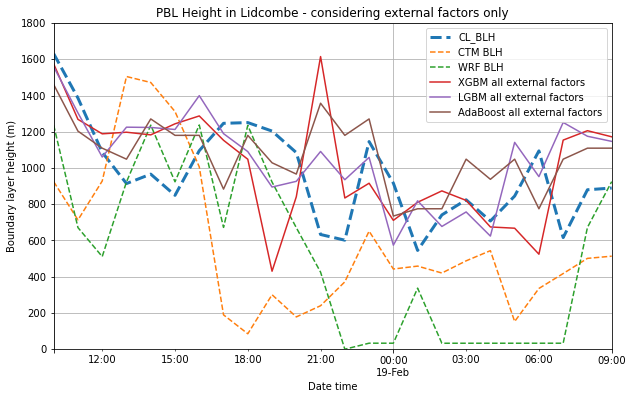

In [73]:
combined_predicted_plots_extfact(df_combined_predicted_lidcombe_extfact, 'PBL Height in Lidcombe - considering external factors only')

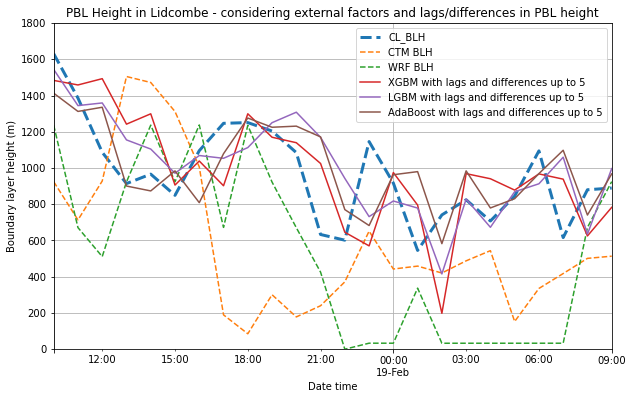

In [74]:
combined_predicted_plots_extfact(df_combined_predicted_lidcombe_wlags_v2, 'PBL Height in Lidcombe - considering external factors and lags/differences in PBL height')

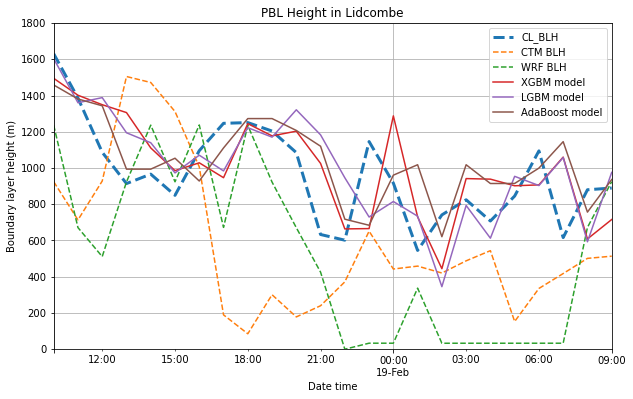

In [75]:
combined_predicted_plots_extfact(df_combined_predicted_lidcombe_wlags_v3, 'PBL Height in Lidcombe')

<h4>3.4 - For final report</h4>

In [76]:
results_df_merriwa_wlags_v3_xgbm = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_wlags_v3['Predicted BLH']]

results_df_merriwa_wlags_v3_lgbm = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                    df_merriwa_lgbm_wlags_v3['Predicted BLH']]

results_df_merriwa_wlags_v3_ada = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 
                                   df_merriwa_ada_wlags_v3['Predicted BLH']]


results_df_lidcombe_wlags_v3_xgbm = [df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_wlags_v3['Predicted BLH']]

results_df_lidcombe_wlags_v3_lgbm = [df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'],
                                     df_lidcombe_lgbm_wlags_v3['Predicted BLH']]

results_df_lidcombe_wlags_v3_ada =[df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'] , 
                                   df_lidcombe_ada_wlags_v3['Predicted BLH']]

col_names_df_wlags_v3_xgbm = ['CTM BLH', 'WRF BLH', 'XGBM model prediction']
col_names_df_wlags_v3_lgbm = ['CTM BLH', 'WRF BLH', 'LGBM model prediction']
col_names_df_wlags_v3_ada = ['CTM BLH', 'WRF BLH', 'AdaBoost model prediction']

df_combined_predicted_merriwa_wlags_v3_xgbm = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v3_xgbm, col_names_df_wlags_v3_xgbm)
df_combined_predicted_merriwa_wlags_v3_lgbm = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v3_lgbm, col_names_df_wlags_v3_lgbm)
df_combined_predicted_merriwa_wlags_v3_ada = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v3_ada, col_names_df_wlags_v3_ada)

df_combined_predicted_lidcombe_wlags_v3_xgbm = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v3_xgbm, col_names_df_wlags_v3_xgbm)
df_combined_predicted_lidcombe_wlags_v3_lgbm = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v3_lgbm, col_names_df_wlags_v3_lgbm)
df_combined_predicted_lidcombe_wlags_v3_ada = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v3_ada, col_names_df_wlags_v3_ada)

In [79]:
def combined_predicted_plots_wlags_v3(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
     
    #Reset legend
    ax.legend()
    ax.grid()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)

<h5>Merriwa plots</h5>

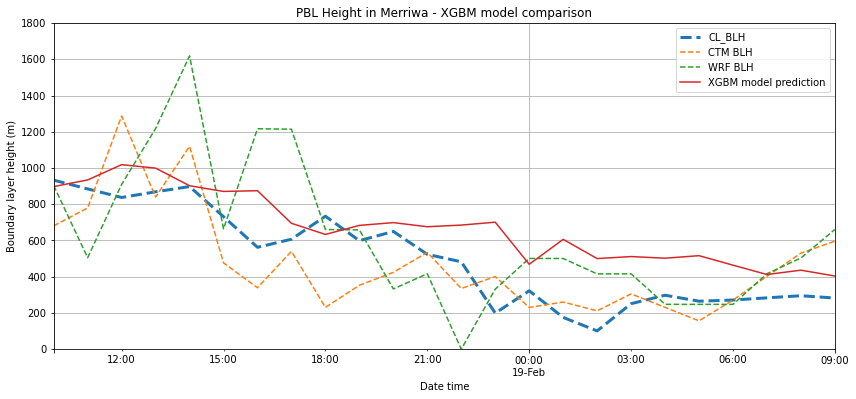

In [80]:
combined_predicted_plots_wlags_v3(df_combined_predicted_merriwa_wlags_v3_xgbm, 'PBL Height in Merriwa - XGBM model comparison')

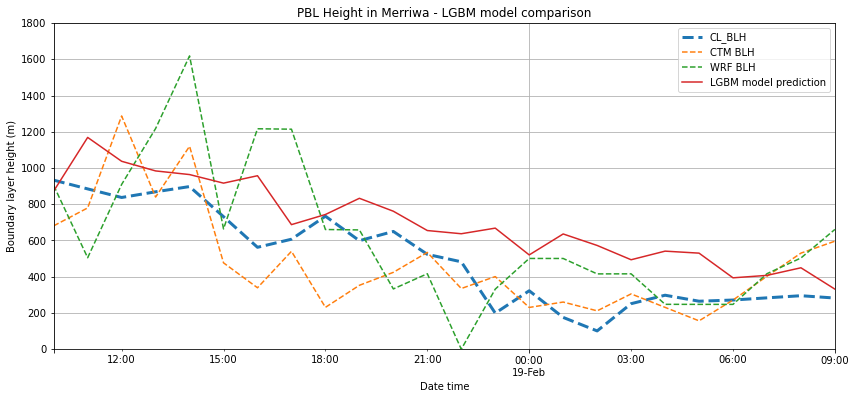

In [81]:
combined_predicted_plots_wlags_v3(df_combined_predicted_merriwa_wlags_v3_lgbm, 'PBL Height in Merriwa - LGBM model comparison')

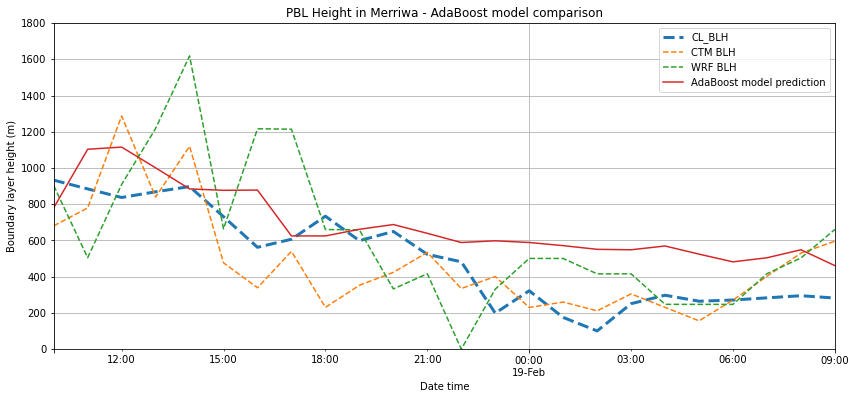

In [82]:
combined_predicted_plots_wlags_v3(df_combined_predicted_merriwa_wlags_v3_ada, 'PBL Height in Merriwa - AdaBoost model comparison')

<h5>Lidcombe plots</h5>

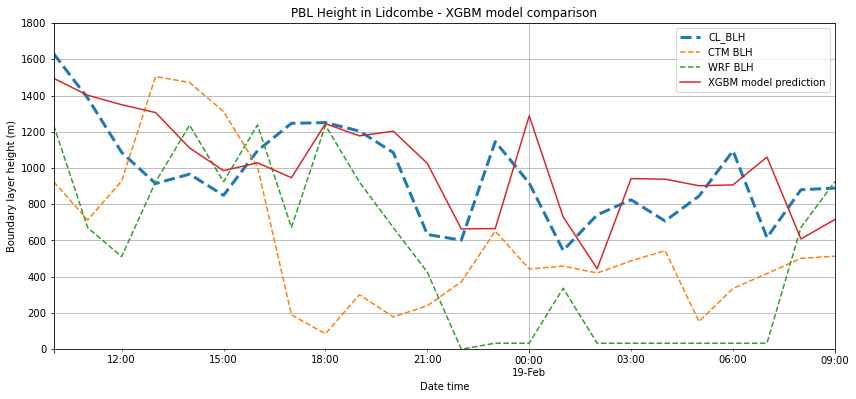

In [83]:
combined_predicted_plots_wlags_v3(df_combined_predicted_lidcombe_wlags_v3_xgbm, 'PBL Height in Lidcombe - XGBM model comparison')

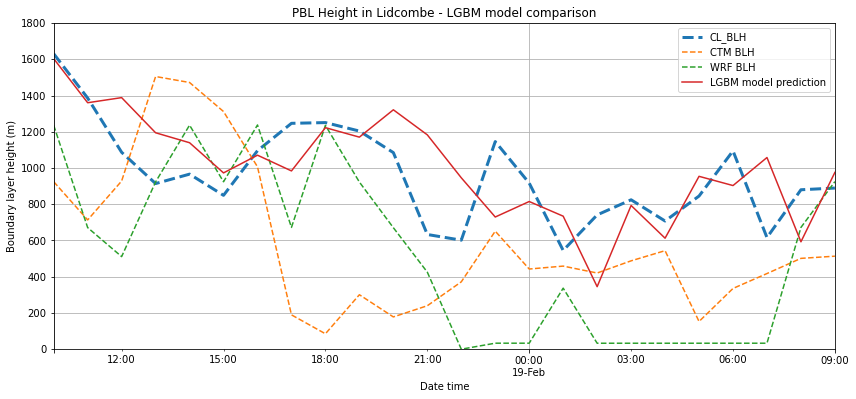

In [84]:
combined_predicted_plots_wlags_v3(df_combined_predicted_lidcombe_wlags_v3_lgbm, 'PBL Height in Lidcombe - LGBM model comparison')

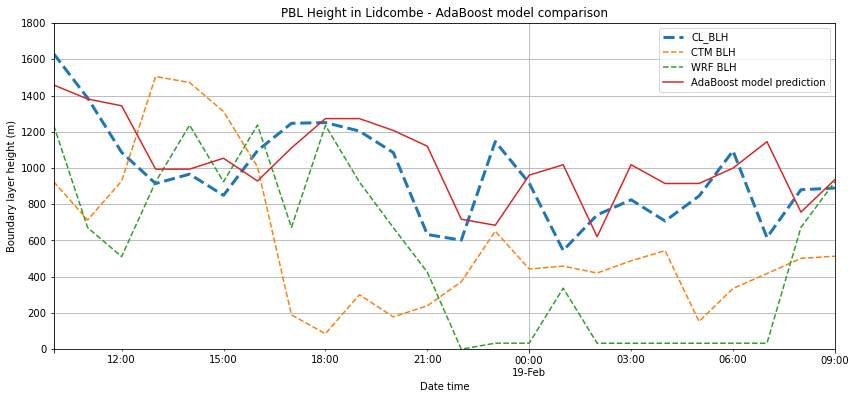

In [85]:
combined_predicted_plots_wlags_v3(df_combined_predicted_lidcombe_wlags_v3_ada, 'PBL Height in Lidcombe - AdaBoost model comparison')

<h4>3.5 - Writing a massive DF for all the results - for comparison purposes</h4>

In [86]:
results_df_merriwa_all = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'],                   
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH'],
        df_merriwa_xgbm_wlags_v3['Predicted BLH'], df_merriwa_lgbm_wlags_v3['Predicted BLH'], df_merriwa_ada_wlags_v3['Predicted BLH']]


results_df_lidcombe_all = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'], df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'],                   
        df_lidcombe_xgbm_wlags['Predicted BLH'], df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'], df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH'],
        df_lidcombe_xgbm_wlags_v3['Predicted BLH'], df_lidcombe_lgbm_wlags_v3['Predicted BLH'], df_lidcombe_ada_wlags_v3['Predicted BLH']]


col_names_df_all = ['CTM BLH', 'WRF BLH', 
           'XGBM all', 'LGBM all', 'AdaBoost all',         
           'XGBM with lags (up to 5)', 'LGBM with lags (up to 5)', 'AdaBoost with lags (up to 5)',
           'XGBM with lags and differences (up to 5)', 'LGBM with lags and differences (up to 5)', 'AdaBoost with lags and differences (up to 5)',
           'XGBM with lags, differences and rolling means (up to 5)', 'LGBM with lags, differences and rolling means (up to 5)', 'AdaBoost with lags, differences and rolling means (up to 5)']


In [87]:
#Function that writes out df for all results
def df_stat_results_combined(df_filled, results_df, train_series, col_names_df):
    index_dict = {0:'IOA', 1:'RMSE', 2:'MAE', 3:'MBE', 4:'DTW DIST', 5:'MASE'}
    
    y_true = df_filled.tail(24)['CL_BLH']
    
    #The first one is the CTM model
    y_pred = results_df[0]
    
    #Intialises the DF
    df_combined = satistical_comps_on_df_to_df(y_true, y_pred, train_series)
    df_combined = df_combined.rename(columns = {0:'CTM model'})
    
    #Iterate
    for i in range(1, len(results_df)):
        y_pred_i = results_df[i]
        df_results_i = satistical_comps_on_df_to_df(y_true, y_pred_i, train_series)        
        df_combined[col_names_df[i]] = df_results_i

    df_combined = df_combined.rename(index = index_dict)    
    
    return df_combined

In [88]:
df_stat_results_combined(df_merriwa_filled, results_df_merriwa_all,df_merriwa_filled.head(142)['CL_BLH'], col_names_df_all).to_csv('Merriwa_summary.csv')

In [89]:
df_stat_results_combined(df_lidcombe_filled, results_df_lidcombe_all,df_lidcombe_filled.head(142)['CL_BLH'], col_names_df_all).to_csv('Lidcombe_summary.csv')